### Načteme data

In [1]:
import numpy as np
import os

PATH = os.path.join("datasets", "07", "imdb")

In [2]:
import pandas as pd

def load_data(file, path=PATH):
    csv = os.path.join(path, file)
    return pd.read_csv(csv)

In [3]:
data = load_data("IMDB Dataset.csv")

### Prozkoumáme a předpřipravíme data

In [4]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
data["label"] = (data["sentiment"] == "positive").astype(int)
data = data.rename(columns={"review":"text"})

In [7]:
data.head()

,text,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


### Rozdělíme dataset na trénovací, testovací a validační

In [8]:
from sklearn.model_selection import train_test_split
train_full, test = train_test_split(data, test_size=0.2, random_state=42)

In [9]:
train, valid = train_test_split(train_full, test_size=0.2, random_state=42)

In [10]:
train.shape

(32000, 3)

In [11]:
valid.shape

(8000, 3)

In [12]:
test.shape

(10000, 3)

### Převod textu na vektor

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

In [14]:
pipeline = Pipeline([
    ('bow', CountVectorizer(max_features=10000)),
    ('tfidf', TfidfTransformer()),
])

In [15]:
X_train = pipeline.fit_transform(train["text"]).todense()
y_train = train["label"]

In [16]:
X_valid = pipeline.transform(valid["text"]).todense()
y_valid = valid["label"]

In [17]:
X_test = pipeline.transform(test["text"]).todense()
y_test = test["label"]

### Vytvoření modelu

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [19]:
model = keras.models.Sequential([
  layers.Dense(16, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid'),  
])


In [20]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [22]:
history = model.fit(X_train,
                    y_train,
                    batch_size=512,
                    epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping])

Epoch 1/100
63/63 [==============================] - 3s 27ms/step - loss: 0.6753 - accuracy: 0.7258 - val_loss: 0.6192 - val_accuracy: 0.8625
Epoch 2/100
63/63 [==============================] - 1s 13ms/step - loss: 0.5981 - accuracy: 0.8655 - val_loss: 0.5388 - val_accuracy: 0.8702
Epoch 3/100
63/63 [==============================] - 1s 13ms/step - loss: 0.5124 - accuracy: 0.8789 - val_loss: 0.4576 - val_accuracy: 0.8786
Epoch 4/100
63/63 [==============================] - 1s 14ms/step - loss: 0.4289 - accuracy: 0.8883 - val_loss: 0.3886 - val_accuracy: 0.8870
Epoch 5/100
63/63 [==============================] - 1s 13ms/step - loss: 0.3608 - accuracy: 0.8962 - val_loss: 0.3358 - val_accuracy: 0.8917
Epoch 6/100
63/63 [==============================] - 1s 13ms/step - loss: 0.3048 - accuracy: 0.9067 - val_loss: 0.2986 - val_accuracy: 0.8956
Epoch 7/100
63/63 [==============================] - 1s 13ms/step - loss: 0.2663 - accuracy: 0.9123 - val_loss: 0.2743 - val_accuracy: 0.8984
Epoch 

### Zobrazíme křivky 

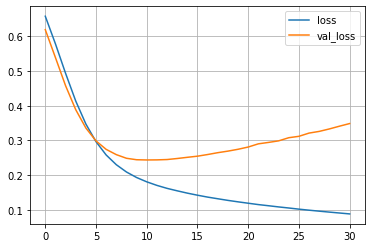

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.grid(True)

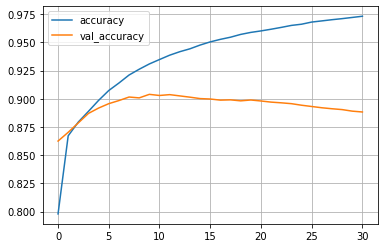

In [24]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.grid(True)

### Vyzkoušíme na testovacích datech

In [25]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2420 - accuracy: 0.8962


[0.24204343557357788, 0.8962000012397766]